In [14]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from network import solve_ode_network, compute_envelope_fc, wc_ode_network
from scipy.signal import hilbert, butter, buttord, filtfilt, lfilter
from scipy.signal import hilbert, hilbert2, savgol_filter, find_peaks
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.signal import iirdesign, sosfilt

In [15]:
mat = loadmat('../references/AAL78/C78.mat')
C = mat['C']
alpha = 0.2
C = alpha * C / np.max(C)

In [16]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [17]:
# Function to apply band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Function to apply low-pass filter
def lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y


In [9]:
def smoothening_envelope(amplitude_env):
    # Initialize the smooth outline matrix with the same shape as amplitude_env
    smooth_outline = np.zeros_like(amplitude_env)
    
    # Iterate over each node and compute the smooth outline
    for i in range(amplitude_env.shape[1]):
        # Find peaks for the current node's amplitude envelope
        peaks, _ = find_peaks(amplitude_env[:, i])
        
        # Handle the case when no peaks are found
        if len(peaks) == 0:
            # If no peaks are found, we could choose to return the original signal,
            # or handle this case according to the specific requirements of the analysis
            smooth_outline[:, i] = amplitude_env[:, i]
            continue
        x_values = np.arange(amplitude_env.shape[0])
        # Interpolate between peaks to create a smoother outline
        peak_interpolation = interp1d(peaks, amplitude_env[peaks, i], kind='cubic', bounds_error=False, fill_value='extrapolate')
        
        # Use the interpolation function to generate the smooth outline for the current node
        smooth_outline[:, i] = peak_interpolation(x_values)
    return smooth_outline


In [20]:
def signal_processing_on_hopf(signal, C, dt, f=12, G=0.5):   
    # Filter parameters
    fs = 1/dt
    band_lowcut = f - 2
    band_highcut = f + 2
    lowpass_cutoff = 0.2

    # Preallocate arrays for filtered signals
    filtered_signal = np.zeros_like(signal)

    # Band-pass filter for each region
    for i in range(78):
        filtered_signal[:, i] = bandpass_filter(signal[:, i], band_lowcut, band_highcut, fs)
        # filtered_signal[:, i] = bandpass_filter_auto_order(signal[:, i], band_lowcut, band_highcut, fs)
        # filtered_signal[:, i] = butter_bandpass_filter(signal[:, i], band_lowcut, band_highcut, fs)
        
    # Calculate the Hilbert transform to get the amplitude envelope
    amplitude_env = np.abs(hilbert(filtered_signal))

    # Smoothening the envelope
    smoothened_env = smoothening_envelope(filtered_signal)

    # Low-pass filter the amplitude envelope
    analytical_signal = hilbert(smoothened_env)
    ultra_slow = np.zeros_like(amplitude_env)

    for i in range(78):
        ultra_slow[:, i] = lowpass_filter(amplitude_env[:, i], lowpass_cutoff, fs) # smoothened_env
        # ultra_slow[:, i] = butter_lowpass_filter(amplitude_env[:, i], lowpass_cutoff, fs) # smoothened_env

    return signal, filtered_signal, analytical_signal, amplitude_env, smoothened_env, ultra_slow


In [102]:
def plot_x_values(x_values, filtered_x, smoothened_env, dt, num_steps):
    # Define the mapping from j values to region names
    region_names = {5: 'Left Frontal Inferior Orbital Area', 17: 'Left Inferior Parietal Area'}
    j = np.array([5, 17])
    time = np.arange(0, num_steps * dt, dt)

    fig, axes = plt.subplots(2, len(j), figsize=(14, len(j)*2))

    for i, region_index in enumerate(j):
        region_name = region_names.get(region_index, f'Region {region_index}')
        axes[0,i].plot(time, x_values[:, region_index], label=f'j={region_index}')
        axes[0,i].set_xlabel('Time (secs)')
        axes[0,i].set_title(f'Original Signal for {region_name}')

        # Filtered signal
        axes[1,i].plot(time, filtered_x[:, region_index], label=f'j={region_index}', color='orange')
        axes[1,i].plot(time, smoothened_env[:, region_index], label=f'j={region_index}', color='green')
        axes[1,i].set_xlabel('Time (secs)')
        axes[1,i].set_title(f'Band-Pass Filtered Signal')

    plt.tight_layout()
    plt.show()

def plot_mean_node_activity(time_series, dt, num_steps):
    """
    Plot the mean activity across all nodes over time.

    :param time_series: 2D numpy array where rows correspond to time steps and
                        columns correspond to nodes.
    """
    # Calculate the mean activity across nodes at each time step
    mean_activity = np.mean(time_series, axis=1)
    time = np.arange(0, num_steps * dt, dt)

    # Plotting
    plt.figure(figsize=(7, 1))
    plt.plot(time, mean_activity, label='Mean Node Activity')
    plt.xlabel('Time (secs)')
    plt.ylabel('Mean Activity')
    plt.title('Mean Activity Across All Nodes Over Time')
    plt.legend()
    plt.show()
    
def plot_signal_processing_stages(x_values, filtered_x, amplitude_env_x, smoothened_env, ultra_slow_x, R_t, mean_amplitude_x):
    # Plot setup
    dt=0.001
    num_steps = 10000
    time = np.arange(0, num_steps * dt, dt)
    fig, axs = plt.subplots(3, 1, figsize=(8, 6))

    # Original signal
    axs[0].plot(time, x_values, label='Original Signal for Left Frontal Inferior Orbital Area')
    axs[0].set_title('Original Signal for Left Frontal Inferior Orbital Area')
    axs[0].set_ylabel('Amplitude')

    # Filtered signal
    axs[1].plot(time, filtered_x, label='Band passed signal 10-14Hz', color='orange')
    axs[1].plot(time, smoothened_env, label='Amplitude Envelope', color='green')
    axs[1].set_title('Band-Pass Filtered Signal 10-14Hz')
    axs[1].set_ylabel('Amplitude')
    axs[1].legend()
    
    # Ultra-slow fluctuations
    axs[2].plot(time, ultra_slow_x, label='Ultra Slow Fluctuations: Low pass 0.2Hz', color='red')
    axs[2].set_title('Ultra-Slow Fluctuations: Low pass 0.2Hz')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Amplitude')

    # Adjusting layout and showing the plot
    plt.tight_layout()
    plt.show()

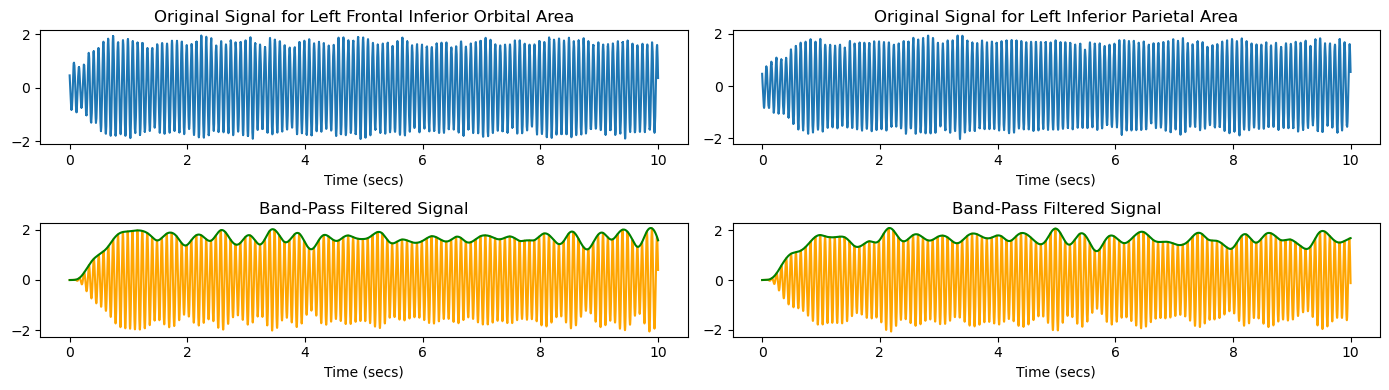

In [22]:
f=12
G=0.5
num_steps = 10000  # total steps
dt = 0.001  # time step
a = 0  # intrinsic dynamics parameters for each neuron"
omega = 2 * np.pi * f  # angular frequencies for each neuron
beta = 0.5 # noise level

x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)

signal = x_values # r_values
x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)

plot_x_values(x_signal, filtered_x, smoothened_env_x, dt, num_steps)

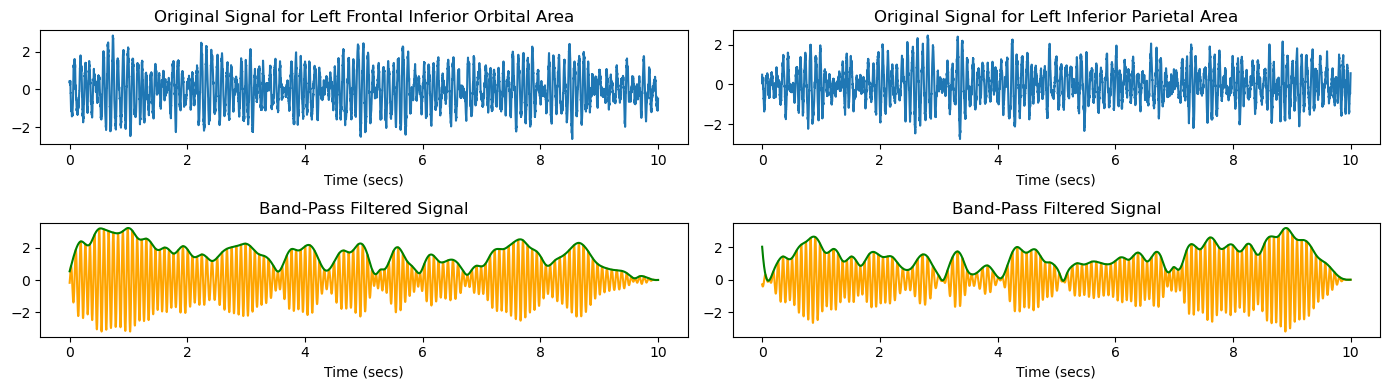

In [13]:
f=12
G=0.5
num_steps = 10000  # total steps
dt = 0.001  # time step
a = 0  # intrinsic dynamics parameters for each neuron
omega = 2 * np.pi * f  # angular frequencies for each neuron
beta = 3 # noise level

x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)

signal = x_values # r_values

x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)

plot_x_values(x_signal, filtered_x, smoothened_env_x, dt, num_steps)
# plot_mean_node_activity(x_signal, dt, num_steps)

In [37]:
import pandas as pd

# Read the file using pandas, assuming it is comma-separated
data = pd.read_csv('data/hb.dat', sep='\s+', header=None)
data

,0,1,2,3,4,5
0,-0.324418,-1.000000,-1.000000,2,4,3
1,-0.451863,-1.139050,-1.139050,2,4,3
2,-0.546160,-1.242370,-1.242370,2,4,3
3,-0.685167,-1.395610,-1.395610,2,4,3
4,-0.886737,-1.620420,-1.620420,2,4,3
...,...,...,...,...,...,...
1065,-1.125050,-1.891790,-1.891790,2,4,3
1066,-0.841346,-1.569470,-1.569470,2,4,3
1067,-0.536793,-1.232090,-1.232090,2,4,3
1068,-0.217939,-0.884208,-0.884208,2,4,3


In [49]:
datacounts = data.groupby(4).size()
datacounts

4
2    445
4    625
dtype: int64

In [75]:
df = data[data[4] == 2]

In [77]:
filtered_df = df[(df[0] > -0.1) & (df[0] < 0.1)]
filtered_df

,0,1,2,3,4,5
829,-0.081224,-1.69136,-1.69136,2,2,3


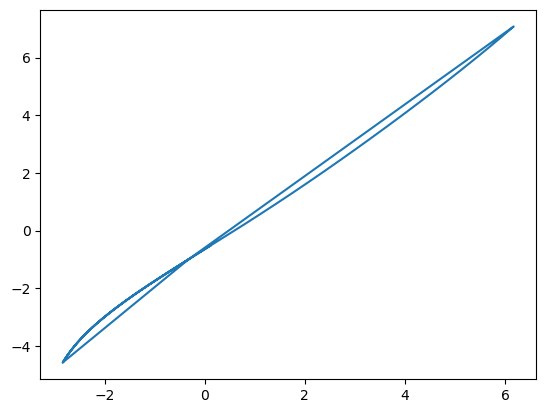

In [60]:
plt.plot(df[0],df[1])

Excitatory Signal


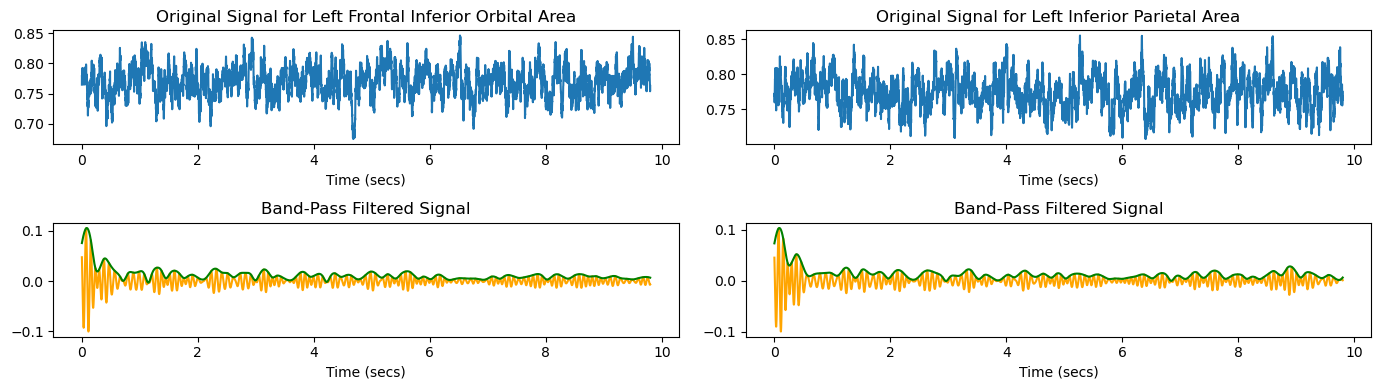

Inhibitory Signal


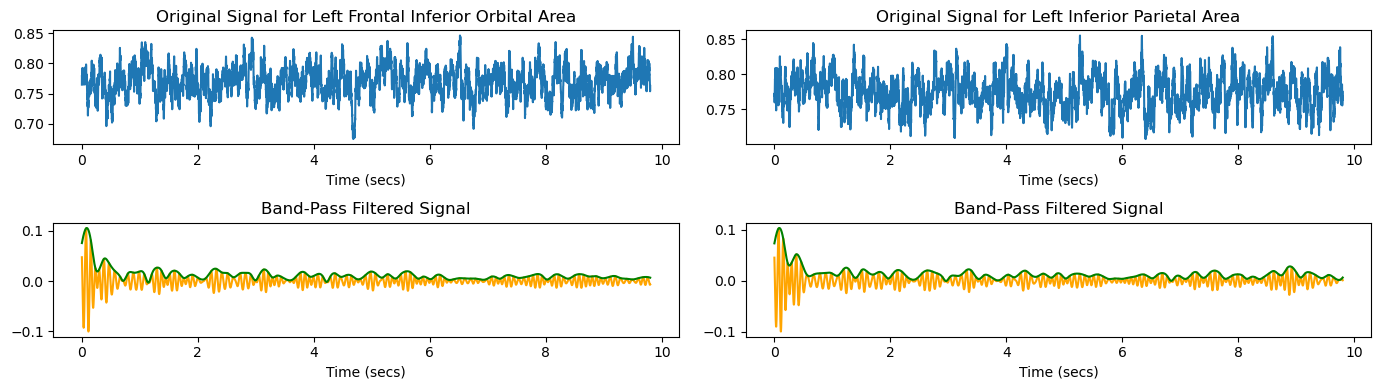

In [87]:
G=0.5
num_steps = 10000  # total steps
dt = 0.001
beta = 0.2

p_i = -1
e_values, i_values = wc_ode_network(p_i, num_steps, dt, beta, C, n=3.5, G=0.5, seed=42)

print("Excitatory Signal")
signal = e_values # r_values
# x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)
_, _, _, _, _, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)
plot_x_values(x_signal[200:], filtered_x[200:], smoothened_env_x[200:], dt, 9800)


print("Inhibitory Signal")
signal = i_values # r_values
x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)
plot_x_values(x_signal[200:], filtered_x[200:], smoothened_env_x[200:], dt, 9800)

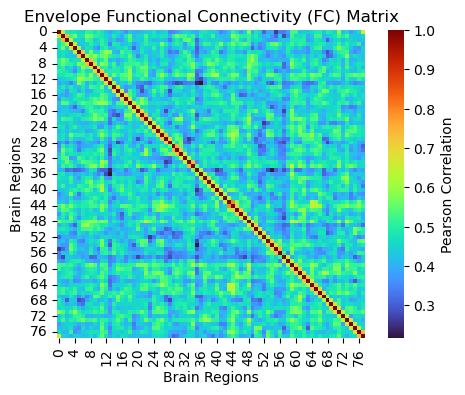

In [84]:
# Compute the Envelope FC matrix
envelope_fc = compute_envelope_fc(ultra_slow_x)

# Plotting the Envelope FC matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(envelope_fc, cmap='turbo', square=True, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Envelope Functional Connectivity (FC) Matrix')
plt.xlabel('Brain Regions')
plt.ylabel('Brain Regions')
plt.show()

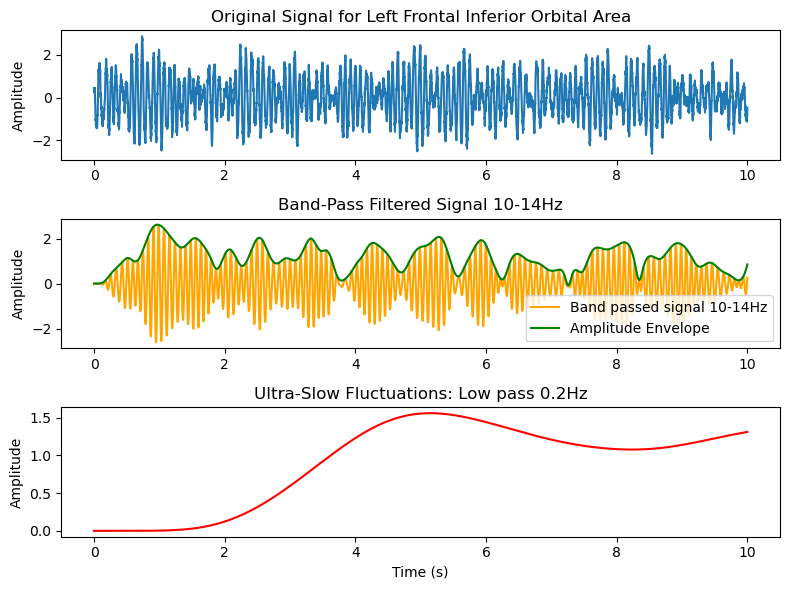

In [103]:
beta = 3 # noise level

x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)

signal = x_values # r_values
x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)

R_t, _ = calculate_kuramoto_and_metastability(analytical_x)
mean_amplitude_x = np.mean(smoothened_env_x, axis=1)

# To plot each of the stages
index = 5
x = x_signal[:,index]
band_pass_fil = filtered_x[:, index]
amplitude_env = amplitude_env_x[:, index]
ultra_slow = ultra_slow_x[:,index]
smoothened_env = smoothened_env_x[:, index]

plot_signal_processing_stages(x, band_pass_fil, amplitude_env, smoothened_env, ultra_slow, R_t, mean_amplitude_x)

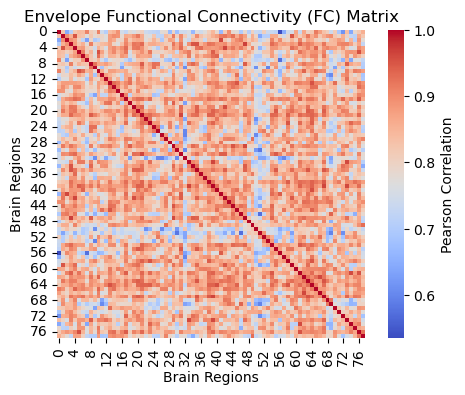

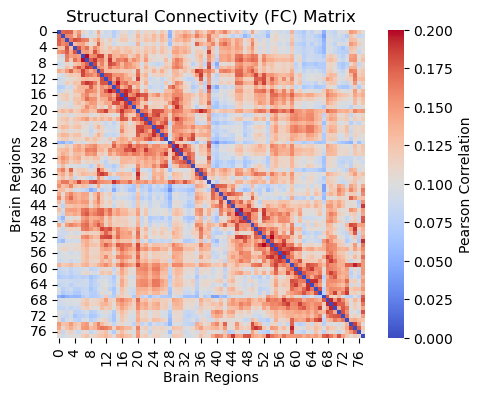

In [64]:
beta = 3 # noise level
num_steps = 30000

x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)

signal = x_values # r_values
x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)

# Compute the Envelope FC matrix
envelope_fc = compute_envelope_fc(ultra_slow_x)

# Plotting the Envelope FC matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(envelope_fc, cmap='coolwarm', square=True, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Envelope Functional Connectivity (FC) Matrix')
plt.xlabel('Brain Regions')
plt.ylabel('Brain Regions')
plt.show()

# Plotting the Envelope FC matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(C, cmap='coolwarm', square=True, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Structural Connectivity (FC) Matrix')
plt.xlabel('Brain Regions')
plt.ylabel('Brain Regions')
plt.show()

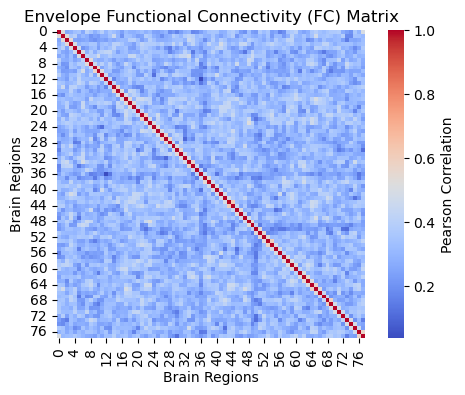

In [65]:
beta = 3 # noise level
num_steps = 300000

x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)

signal = x_values # r_values
x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)

# Compute the Envelope FC matrix
envelope_fc = compute_envelope_fc(ultra_slow_x)

# Plotting the Envelope FC matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(envelope_fc, cmap='coolwarm', square=True, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Envelope Functional Connectivity (FC) Matrix')
plt.xlabel('Brain Regions')
plt.ylabel('Brain Regions')
plt.show()

In [ ]:
beta = 0.2 # noise level
num_steps = 30000
dt = 0.001  # time step
pi = -1  # intrinsic dynamics parameters for each neuron

e_values, i_values = wc_ode_network(pi, num_steps, dt, beta, C, n, G=0.5)

signal = x_values # r_values
x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)

# Compute the Envelope FC matrix
envelope_fc = compute_envelope_fc(ultra_slow_x)

# Plotting the Envelope FC matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(envelope_fc, cmap='coolwarm', square=True, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Envelope Functional Connectivity (FC) Matrix')
plt.xlabel('Brain Regions')
plt.ylabel('Brain Regions')
plt.show()

## Metastability

### Fig 6c.

In [ ]:
# Function to calculate Kuramoto order parameter R(t) and metastability
def calculate_kuramoto_and_metastability(analytical_x):
    # Calculate the instantaneous phase φk(t) for each brain region
    instantaneous_phase = np.angle(analytical_x)

    # Calculate the Kuramoto order parameter R(t) over time
    R_t = np.abs(np.sum(np.exp(1j * instantaneous_phase), axis=1))/78

    # Calculate metastability as the standard deviation of the Kuramoto order parameter
    metastability = np.std(R_t)
    
    return R_t, metastability

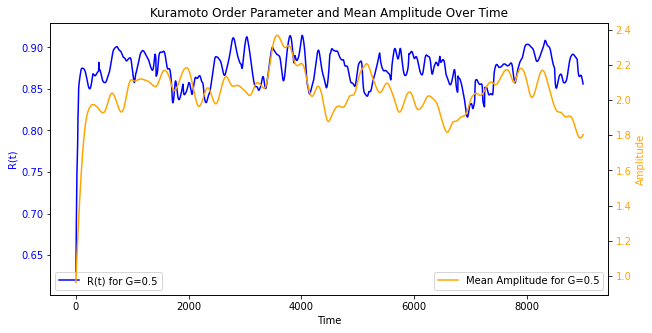

In [114]:
_, _, analytical_x, amplitude_env_x, smoothened_env_x, _ = signal_processing_on_hopf(signal, C, dt, f, G)
R_t, _ = calculate_kuramoto_and_metastability(analytical_x)
mean_amplitude_x = np.mean(smoothened_env_x, axis=1)

# Create a figure and a first axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot R_t (Kuramoto Order Parameter) on the first axis (ax1) in blue
ax1.plot(R_t[:9000], label=f'R(t) for G={G}', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('R(t)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='lower left')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot mean_amplitude_x on the second axis (ax2) in orange
ax2.plot(mean_amplitude_x[:9000], label=f'Mean Amplitude for G={G}', color='orange')
ax2.set_ylabel('Amplitude', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='lower right')

# Title of the combined plot
plt.title('Kuramoto Order Parameter and Mean Amplitude Over Time')

# Show the plot with two y-axes
plt.show()

## CCD

In [115]:
f=12
G=0.5
num_steps = 20000  # total steps
dt = 0.001  # time step
a = 0.0  # intrinsic dynamics parameters for each neuron
omega = 2 * np.pi * f  # angular frequencies for each neuron
beta = 5 # noise level

x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)
r_values = np.sqrt(x_values**2 + y_values**2)

signal = x_values # r_values
x_signal, filtered_x, analytical_x, amplitude_env_x, smoothened_env_x, ultra_slow_x =  signal_processing_on_hopf(signal, C, dt, f=12, G=0.5)

### Debugging CCD

In [146]:
# instantaneous_phase = np.random.rand(10, 4)
# num_time_points, num_brain_regions = instantaneous_phase.shape

# # Step 1: Calculate V(t) for each time step
# V_t = []
# for t in range(num_time_points):
#     phase_diff = np.abs(instantaneous_phase[t, :, None] - instantaneous_phase[t, None, :])
#     print(f"1:{instantaneous_phase[t, :, None]}")
#     print(f"2:{instantaneous_phase[t, None, :]}")
#     cos_phase_diff = np.cos(phase_diff)
#     print(f"3:{cos_phase_diff}")
#     # We exclude the diagonal to not include the coherence of a node with itself
#     np.fill_diagonal(cos_phase_diff, 0)
#     V_t.append(cos_phase_diff[np.triu_indices(num_brain_regions, k=1)])
#     print(f"4:{cos_phase_diff[np.triu_indices(num_brain_regions, k=1)]}")
#     # if(t%4000==0):
#     #     print(cos_phase_diff.shape)
#     #     print((cos_phase_diff[np.triu_indices(num_brain_regions, k=1)].shape))
# V_t = np.array(V_t)
# print(V_t)
# print(V_t.shape)

(20000, 78)
(20000, 3003)
(20000, 20000)


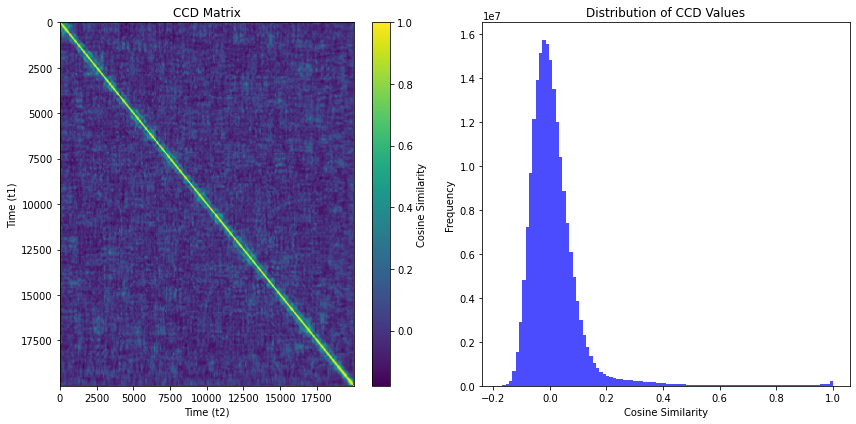

In [116]:
instantaneous_phase = np.angle(analytical_x)
print(instantaneous_phase.shape)
# Number of time points and brain regions
num_time_points, num_brain_regions = instantaneous_phase.shape

# Step 1: Calculate V(t) for each time step
V_t = []
for t in range(num_time_points):
    phase_diff = np.abs(instantaneous_phase[t, :, None] - instantaneous_phase[t, None, :])
    cos_phase_diff = np.cos(phase_diff)
    # We exclude the diagonal to not include the coherence of a node with itself
    np.fill_diagonal(cos_phase_diff, 0)
    V_t.append(cos_phase_diff[np.triu_indices(num_brain_regions, k=1)])
V_t = np.array(V_t)
print(V_t.shape)
# Step 2: Calculate the CCD matrix
CCD = np.corrcoef(V_t)
print(CCD.shape)
CCD_values = CCD[np.triu_indices_from(CCD, k=1)]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Step 3: Plot the CCD matrix on the first subplot
im = axes[0].imshow(CCD, cmap='viridis', origin='lower', aspect='auto')
fig.colorbar(im, ax=axes[0], label='Cosine Similarity')
axes[0].set_title('CCD Matrix')
axes[0].set_xlabel('Time (t2)')
axes[0].set_ylabel('Time (t1)')
axes[0].invert_yaxis()  # Invert the y-axis

# Step 4: Plot the CCD distribution on the second subplot
axes[1].hist(CCD_values, bins=100, color='blue', alpha=0.7)
axes[1].set_title('Distribution of CCD Values')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Metstability vs. Coupling Strength

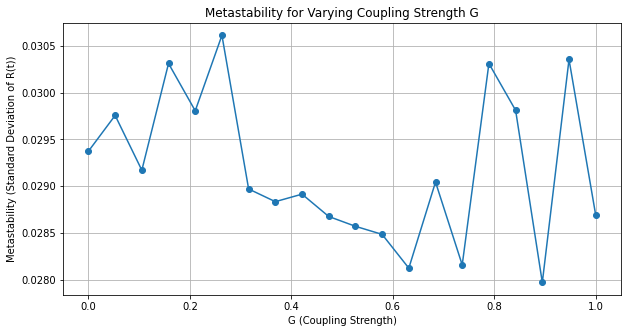

In [117]:
# Vary the coupling strength G from 0 to 1 with 20 points
f=12
omega = 2 * np.pi * f
G_values = np.linspace(0, 1, 20)
metastabilities = []

# Calculate metastability for varying G and plot the metastability
for G in G_values:
    x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)
    _, _, analytical_x, _, _, _ = signal_processing_on_hopf(x_values, C, dt, f, G)
    _, metastability = calculate_kuramoto_and_metastability(analytical_x)
    metastabilities.append(metastability)

# Plot metastability over G values
plt.figure(figsize=(10, 5))
plt.plot(G_values, metastabilities, marker='o')
plt.title('Metastability for Varying Coupling Strength G')
plt.xlabel('G (Coupling Strength)')
plt.ylabel('Metastability (Standard Deviation of R(t))')
plt.grid(True)
plt.show()

### Metastability vs carrier frequencies

/opt/homebrew/lib/python3.9/site-packages/scipy/signal/_signaltools.py:2300: RuntimeWarning: invalid value encountered in multiply
  x = sp_fft.ifft(Xf * h, axis=axis)
/opt/homebrew/lib/python3.9/site-packages/scipy/signal/_signaltools.py:2300: RuntimeWarning: overflow encountered in multiply
  x = sp_fft.ifft(Xf * h, axis=axis)
/opt/homebrew/lib/python3.9/site-packages/scipy/signal/_arraytools.py:100: RuntimeWarning: invalid value encountered in subtract
  ext = np.concatenate((2 * left_end - left_ext,
/opt/homebrew/lib/python3.9/site-packages/scipy/signal/_signaltools.py:4070: RuntimeWarning: overflow encountered in multiply
  (y, zf) = lfilter(b, a, ext, axis=axis, zi=zi * x0)
/opt/homebrew/lib/python3.9/site-packages/scipy/signal/_arraytools.py:100: RuntimeWarning: overflow encountered in multiply
  ext = np.concatenate((2 * left_end - left_ext,


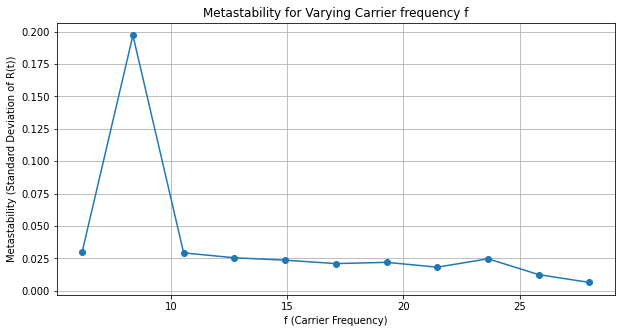

In [118]:
# Vary the frequencies from 4 to 28 with 12 points
G=0.5
f_values = np.linspace(4, 28, 12)
metastabilities = []

# Calculate metastability for varying G and plot the metastability
for f in f_values:
    omega = 2 * np.pi * f
    x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)
    _, _, analytical_x, _, _, _ = signal_processing_on_hopf(x_values, C, dt, f, G)
    _, metastability = calculate_kuramoto_and_metastability(analytical_x)
    metastabilities.append(metastability)

# Plot metastability over G values
plt.figure(figsize=(10, 5))
plt.plot(f_values, metastabilities, marker='o')
plt.title('Metastability for Varying Carrier frequency f')
plt.xlabel('f (Carrier Frequency)')
plt.ylabel('Metastability (Standard Deviation of R(t))')
plt.grid(True)
plt.show()